## Importing Libraries:

In [3]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
%matplotlib inline  

## Loading Dataset:

In [4]:
aislesDF = pd.read_csv('aisles.csv')
departmentsDF = pd.read_csv('departments.csv')
orderProductsPriorDF = pd.read_csv('order_products__prior.csv')
orderProductsTrainDF = pd.read_csv('order_products__train.csv')
ordersDF = pd.read_csv('clean_orders.csv')
productsDF = pd.read_csv('products.csv')

## Product Features:

In [5]:
productsRaw = pd.DataFrame()

productsRaw['ordersTotal'] = orderProductsPriorDF.groupby(
    orderProductsPriorDF.product_id).size().astype(np.int32)

productsRaw['reordersTotal'] = orderProductsPriorDF['reordered'].groupby(
    orderProductsPriorDF.product_id).sum().astype(np.float32)

productsRaw['reorder_rate'] = (productsRaw.reordersTotal / productsRaw.ordersTotal).astype(np.float32)

products = productsDF.join(productsRaw, on = 'product_id')
products.head()

,product_id,product_name,aisle_id,department_id,ordersTotal,reordersTotal,reorder_rate
0,1,Chocolate Sandwich Cookies,61,19,1852.0,1136.0,0.613391
1,2,All-Seasons Salt,104,13,90.0,12.0,0.133333
2,3,Robust Golden Unsweetened Oolong Tea,94,7,277.0,203.0,0.732852
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,329.0,147.0,0.446809
4,5,Green Chile Anytime Sauce,5,13,15.0,9.0,0.600000


## User Features:

In [6]:
ordersDF.head()

,Unnamed: 0,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1,2398795,1,prior,2,3,7,15.0
1,2,473747,1,prior,3,3,12,21.0
2,3,2254736,1,prior,4,4,7,29.0
3,4,431534,1,prior,5,4,15,28.0
4,5,3367565,1,prior,6,2,7,19.0


In [7]:
#ordersDF.drop('Unnamed: 0',axis=1,inplace=True)

In [8]:
ordersDF.head()

,Unnamed: 0,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1,2398795,1,prior,2,3,7,15.0
1,2,473747,1,prior,3,3,12,21.0
2,3,2254736,1,prior,4,4,7,29.0
3,4,431534,1,prior,5,4,15,28.0
4,5,3367565,1,prior,6,2,7,19.0


In [9]:
# priors: merge ordersDF to order_products_priorDF
ordersDF.set_index('order_id', inplace = True, drop = False)
priors = pd.merge(orderProductsPriorDF, ordersDF, how = 'left', on = 'order_id')

In [10]:
users = pd.DataFrame()
users['total_user'] = priors.groupby('product_id').size()
users['all_users'] = priors.groupby('product_id')['user_id'].apply(set)
users['total_distinct_users_perProduct'] = users.all_users.map(len)

In [11]:
priors.head()

,order_id,product_id,add_to_cart_order,reordered,Unnamed: 0,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,3355525.0,202279.0,prior,3.0,5.0,9.0,8.0
1,2,28985,2,1,3355525.0,202279.0,prior,3.0,5.0,9.0,8.0
2,2,9327,3,0,3355525.0,202279.0,prior,3.0,5.0,9.0,8.0
3,2,45918,4,1,3355525.0,202279.0,prior,3.0,5.0,9.0,8.0
4,2,30035,5,0,3355525.0,202279.0,prior,3.0,5.0,9.0,8.0


In [12]:
customersRaw = pd.DataFrame()
customersRaw['avgDaysBetwOrders'] = ordersDF.groupby(
    'user_id')['days_since_prior_order'].mean().astype(np.float32)

customersRaw['NumberOfOrders'] = ordersDF.groupby('user_id').size().astype(np.int16)

In [13]:
customers = pd.DataFrame()

customers['total_items'] = priors.groupby('user_id').size().astype(np.int16)
customers['all_products'] = priors.groupby('user_id')['product_id'].apply(set)
customers['total_unique_items'] = customers.all_products.map(len).astype(np.float32)

customers = customers.join(customersRaw)
customers['avg_per_cart'] = (customers.total_items / customers.NumberOfOrders).astype(np.float32)

## User & Product Features:

In [14]:
customerProd = priors.copy()
customerProd['user_product'] = (customerProd.product_id + 
                                    customerProd.user_id * 100000).fillna(0).astype(np.int64)

customerProd = customerProd.sort_values('order_number')

customerProd = customerProd.groupby('user_product', sort = False).agg(
{'order_id': ['size', 'last', 'first'], 'add_to_cart_order': 'sum'})

customerProd.columns = ['numbOfOrders', 'last_order_id', 'first_order_id','sum_add_to_cart_order']
customerProd.astype(
    {'numbOfOrders': np.int16, 'last_order_id': np.int32, 'first_order_id': np.int32, 'sum_add_to_cart_order': np.int16}, 
    inplace=True)

,numbOfOrders,last_order_id,first_order_id,sum_add_to_cart_order
user_product,,,,
12029848415,6,1172973,1710892,70
11038609387,2,2419986,2146595,23
11038648090,2,2694518,2146595,37
11038638465,1,2146595,2146595,15
11038613203,3,2694518,2146595,50
11038648183,1,2146595,2146595,17
11038618987,1,2146595,2146595,18
11038619935,1,2146595,2146595,19
11038608859,2,1370559,2146595,33


In [15]:
customerProd.head()

,numbOfOrders,last_order_id,first_order_id,sum_add_to_cart_order
user_product,,,,
12029848415,6,1172973,1710892,70
11038609387,2,2419986,2146595,23
11038648090,2,2694518,2146595,37
11038638465,1,2146595,2146595,15
11038613203,3,2694518,2146595,50


In [16]:
priors.head()

,order_id,product_id,add_to_cart_order,reordered,Unnamed: 0,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,3355525.0,202279.0,prior,3.0,5.0,9.0,8.0
1,2,28985,2,1,3355525.0,202279.0,prior,3.0,5.0,9.0,8.0
2,2,9327,3,0,3355525.0,202279.0,prior,3.0,5.0,9.0,8.0
3,2,45918,4,1,3355525.0,202279.0,prior,3.0,5.0,9.0,8.0
4,2,30035,5,0,3355525.0,202279.0,prior,3.0,5.0,9.0,8.0


## Function to get all Features:

In [17]:
def get_features(specified_orders, given_labels = False):

    orders_list = []
    products_list = []
    labels = []
    
    training_index = set(orderProductsTrainDF.index)
    
    for row in specified_orders.itertuples():
        user_id = row.user_id
        order_id = row.order_id
        
        user_products = customers['all_products'][user_id]
        products_list += user_products
        orders_list += [order_id] * len(user_products)
        
        if given_labels:
            labels += [(order_id, product) in training_index for product in user_products]
        
    DF = pd.DataFrame({'order_id': orders_list, 'product_id': products_list}, dtype = np.int32)
    labels = np.array(labels, dtype = np.int8)
        
    
    DF['user_id'] = DF.order_id.map(ordersDF.user_id)
    DF['user_total_orders'] = DF.user_id.map(customers.NumberOfOrders)
    DF['user_total_items'] = DF.user_id.map(customers.total_items)
    DF['total_unique_items'] = DF.user_id.map(customers.total_unique_items)
    DF['user_avgDaysBetwOrders'] = DF.user_id.map(customers.avgDaysBetwOrders)
    DF['user_avg_per_cart'] = DF.user_id.map(customers.avg_per_cart) 
    DF['order_hour_of_day'] = DF.order_id.map(ordersDF.order_hour_of_day)
    DF['days_since_prior_order'] = DF.order_id.map(ordersDF.days_since_prior_order)
    DF['daysSincePrior_avgDaysBetw_ratio'] = DF.days_since_prior_order / DF.user_avgDaysBetwOrders
    DF['aisle_id'] = DF.product_id.map(products.aisle_id)
    DF['department_id'] = DF.product_id.map(products.department_id)
    DF['product_order'] = DF.product_id.map(products.ordersTotal)
    DF['product_reorder'] = DF.product_id.map(products.reordersTotal)
    DF['product_reorder_rate'] = DF.product_id.map(products.reorder_rate)
    DF['product_distinct_user'] = DF.product_id.map(users.total_distinct_users_perProduct)
    DF['user_product_id']  = (DF.product_id + DF.user_id * 100000).astype(np.int64)
    DF.drop(['user_id'], axis = 1, inplace = True)
    DF['CP_numOrders'] = DF.user_product_id.map(customerProd.numbOfOrders)
    DF['CP_orders_ratio'] = DF.CP_numOrders / DF.user_total_orders
    DF['CP_last_order_id'] = DF.user_product_id.map(customerProd.last_order_id)
    DF['CP_avg_pos_inCart'] = DF.user_product_id.map(customerProd.sum_add_to_cart_order) / DF.CP_numOrders
    DF['CP_order_since_last'] = DF.user_total_orders - DF.CP_last_order_id.map(ordersDF.order_number)
    DF['CP_hour_vs_last'] = abs(DF.order_hour_of_day - DF.CP_last_order_id.map(
    ordersDF.order_hour_of_day)).map(lambda x: min(x, 24 - x)).astype(np.int8)

    
    DF.drop(['CP_last_order_id', 'user_product_id'], axis = 1, inplace = True)
    return(DF, labels)


## Train and Test Split:

In [18]:
test = ordersDF[ordersDF.eval_set == 'test']
train = ordersDF[ordersDF.eval_set == 'train']

orderProductsTrainDF.set_index(['order_id', 'product_id'], inplace = True, drop = False)

## Features to train the model:

In [20]:
features_to_use = ['user_total_orders', 'user_total_items', 'total_unique_items', 
                  'user_avgDaysBetwOrders', 'user_avg_per_cart', 'order_hour_of_day',
                  'days_since_prior_order', 'daysSincePrior_avgDaysBetw_ratio',
                  'aisle_id', 'department_id', 'product_order', 'product_reorder',
                  'product_reorder_rate', 'CP_numOrders', 'CP_orders_ratio', 
                  'CP_avg_pos_inCart', 'CP_order_since_last', 'CP_hour_vs_last',
                  'product_distinct_user']

In [21]:
train_train = train.sample(frac = 0.8, random_state=200)
train_test = train.drop(train_train.index)

In [23]:
df_train_train, labels_train_train = get_features(train_train, given_labels=True)

df_train_test, labels_train_test = get_features(train_test,given_labels=True)

## Logistic Regression Train model:

In [36]:
X_train = df_train_train[features_to_use]

In [37]:
y_train = labels_train_train

In [38]:
X_test = df_train_test[features_to_use]

In [39]:
y_test=labels_train_test

In [40]:
X_train.fillna(0,inplace=True)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:3035: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [41]:
X_test.fillna(0,inplace=True)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:3035: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score 

In [43]:
#Logistic Regression model
clf=(LogisticRegression(C=0.02))

In [44]:
#fitting the model
clf.fit(X_train, y_train)

LogisticRegression(C=0.02, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [45]:
#predictions
pred=clf.predict(X_test)

In [46]:
#accuracy score for the logistic regression model
print(accuracy_score(pred, y_test))

0.8975106126380781


In [47]:
train_pred = clf.predict(X_train)
print("CONFUSION MATRIX :")
print(' ')
print("For Train Data:")
y_train_pred_bow = clf.predict(X_train)
print(confusion_matrix(y_train, y_train_pred_bow))
print(' ')
print("For Test Data:")
y_test_pred_bow = clf.predict(X_test)
print(confusion_matrix(y_test, pred))

CONFUSION MATRIX :
 
For Train Data:
[[5694581    3832]
 [ 638131    3823]]
 
For Test Data:
[[1418975     809]
 [ 161337     955]]


In [48]:
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

          0       0.90      1.00      0.95   1419784
          1       0.54      0.01      0.01    162292

avg / total       0.86      0.90      0.85   1582076



In [49]:
print(classification_report(y_train, y_train_pred_bow))

             precision    recall  f1-score   support

          0       0.90      1.00      0.95   5698413
          1       0.50      0.01      0.01    641954

avg / total       0.86      0.90      0.85   6340367



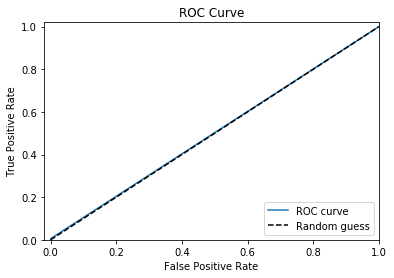

In [51]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
%matplotlib inline

fpr, tpr, thresholds = roc_curve(y_test, pred)

# create plot
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('ROC Curve')
_ = plt.xlim([-0.02, 1])
_ = plt.ylim([0, 1.02])
_ = plt.legend(loc="lower right")

In [52]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, pred)

0.5026573250975664